In [5]:
%matplotlib ipympl

In [1]:
from add_ckpt_path import add_path_to_dust3r
add_path_to_dust3r("src/somefile.blah")
from argparse import Namespace
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy.spatial
import shutil
import torch
from torch.utils.data._utils.collate import default_collate
from torchvision import transforms
from viser_utils import PointCloudViewer

args = Namespace(resolution=(512, 384), device="cuda", vis_threshold=1.5, size=512, dataset_root="data/neural_rgbd",
                 sequence_dir="test_sequences/no_visual_overlap")

In [ ]:
from eval.mv_recon.data import NRGBD

dataset = NRGBD(
            split="test",
            ROOT=args.dataset_root,
            resolution=args.resolution,
            num_seq=1,
            full_video=True,
            kf_every=10
        )

scene_id = 1
seq_data = default_collate(dataset[scene_id])
undo_imgnorm = transforms.Normalize((-1, -1, -1), (2, 2, 2))

Found 9 sequences in split test


In [3]:
def cluster_imgs_by_loc(coords, num_clusters=20):
    dists = scipy.spatial.distance.cdist(coords, coords)
    cluster_size = len(coords) // num_clusters
    remainder = len(coords) % num_clusters
    avail_inds = np.ones(coords.shape[0], dtype=bool)
    num_curr_clusts = 0
    img_clusters = []
    while avail_inds.any():
        curr_cluster_size = cluster_size + 1 if num_curr_clusts < remainder else cluster_size
        cluster_centre = np.argmax(avail_inds)
        avail_inds[cluster_centre] = False
        closest_inds = np.argsort(dists[cluster_centre])
        avail_sorted_inds = closest_inds[avail_inds[closest_inds]]
        if avail_sorted_inds.shape[0] < curr_cluster_size - 1:
            print(f"Image #{cluster_centre}: only {avail_sorted_inds.shape[0]} other images remaining")
        cluster_inds = avail_sorted_inds[:curr_cluster_size - 1]
        avail_inds[cluster_inds] = False
        num_curr_clusts += 1
        img_cluster = []
        for cluster_ind in cluster_inds:
            img_cluster.append(cluster_ind)
        img_cluster.append(cluster_centre)
        img_clusters.append(np.array(sorted(img_cluster)))
    return img_clusters


def plot_clusters(img_clusters, coords, cam_poses):
    cluster_colors = []
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection="3d")
    for cluster_i, cluster in enumerate(img_clusters):
        color = plt.get_cmap("viridis")(0.33 * (cluster_i % 4))
        for coord, pose in zip(coords[cluster], cam_poses[cluster]):
            ax.scatter(coord[0], coord[1], coord[2], color=color)
            cam_ext = coord + pose[2] / 10
            ax.plot(*[[coord[i], cam_ext[i]] for i in range(3)], color=color)
        # ax.scatter(coords[cluster, 0], coords[cluster, 1], coords[cluster, 2], color=color)
        ax.text(coords[cluster[cluster.shape[0] // 2], 0], coords[cluster[cluster.shape[0] // 2], 1],
                coords[cluster[cluster.shape[0] // 2], 2], s=str(cluster_i))
        cluster_colors.append(color)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    return fig, cluster_colors

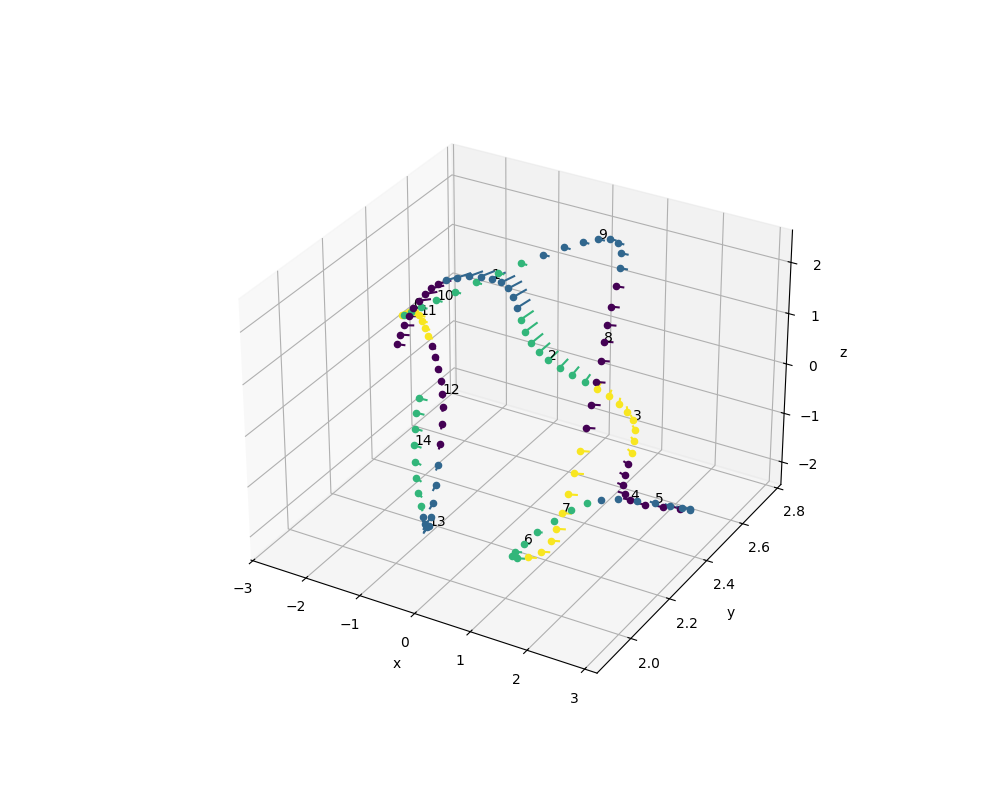

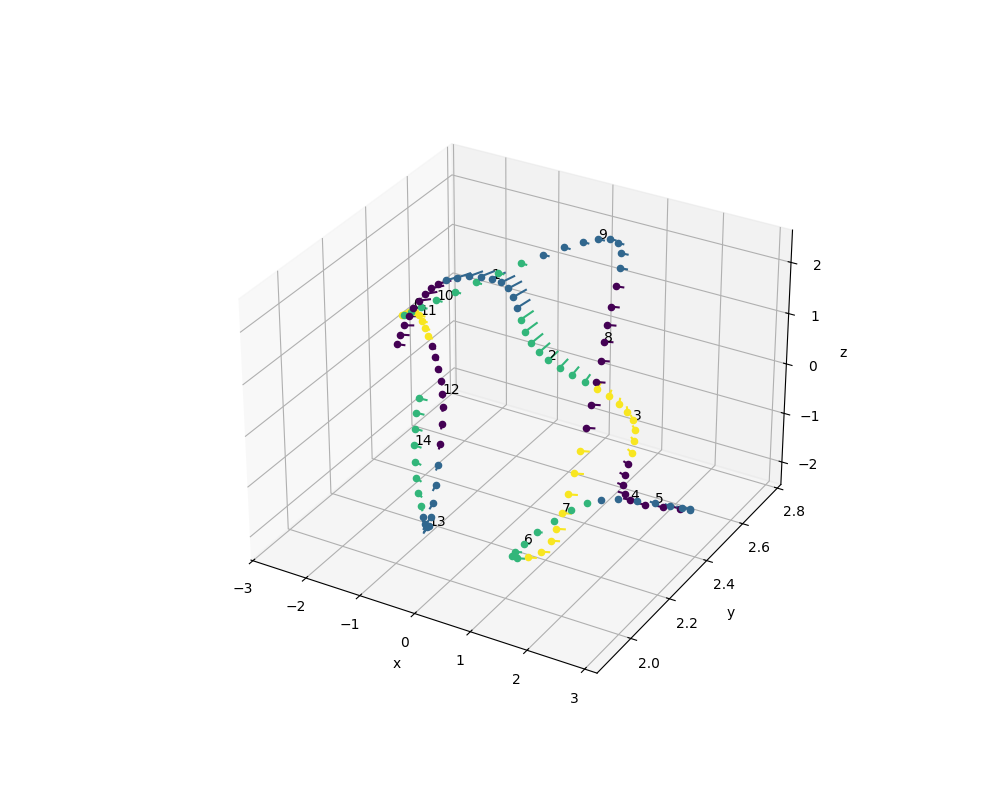

In [6]:
coords = seq_data["camera_pose"][:, :3, 3]
cam_poses = seq_data["camera_pose"][:, :3, :3]
img_clusters = np.array_split(np.arange(len(coords)), 15)   # cluster_imgs_by_loc(coords)
img_dist_fig, cluster_colors = plot_clusters(img_clusters, coords, cam_poses)
img_dist_fig.show()

In [ ]:
clusters_to_choose = [2, 8]
selected_imgs = np.concatenate([img_clusters[cluster_i] for cluster_i in clusters_to_choose])
select_pts3d = seq_data["pts3d"].numpy()[selected_imgs]
select_img = seq_data["img"][torch.from_numpy(selected_imgs)]
select_cam_pose = seq_data["camera_pose"].numpy()[selected_imgs]
select_cam_intr = seq_data["camera_intrinsics"].numpy()[selected_imgs]

pts3ds_to_vis = [pts3d * [-1, -1, 1] for pts3d in select_pts3d]
colors_pytorch = [undo_imgnorm(img) for img in select_img]
colors_to_vis = [0.5 * (pt_img.permute(1, 2, 0).unsqueeze(0) + 1.0).numpy() for pt_img in colors_pytorch]
confidence = [np.ones(colors_to_vis[0].shape[1:3])[np.newaxis, ...] * 2 for _ in range(len(selected_imgs))]

R_c2w = np.stack([(cam_pose[:3, :3].T * [-1, -1, 1]).T for cam_pose in select_cam_pose])
t_c2w = np.stack([cam_pose[:3, 3] * [-1, -1, 1] for cam_pose in select_cam_pose])

focal = [cam_intr[0, 0].item() for cam_intr in select_cam_intr]
pp = np.array(colors_to_vis[0].shape[1:3])[np.newaxis, ...].repeat(len(selected_imgs), axis=0)
cam_dict = {"focal": focal, "pp": pp, "R": R_c2w, "t": t_c2w}
edge_colors = [cluster_colors[cluster_i][:3] for cluster_i in clusters_to_choose for _ in range(len(img_clusters[cluster_i]))]

In [24]:
for img_ind in selected_imgs:
    img_name = f"img{os.path.basename(seq_data['label'][img_ind])}.png"
    img_src_path = os.path.join(args.dataset_root, dataset.scene_list[scene_id], "images", img_name)
    img_dest_path = os.path.join(args.sequence_dir, f"{dataset.scene_list[scene_id]}_{img_name}")
    shutil.copy(img_src_path, img_dest_path)
    
with open(os.path.join(args.sequence_dir, "image_source.txt"), "w") as soure_path_file:
    soure_path_file.write(args.dataset_root)

In [ ]:
viewer = PointCloudViewer(
    None,
    None,
    pts3ds_to_vis,
    colors_to_vis,
    confidence,
    cam_dict,
    device=args.device,
    edge_color_list=edge_colors,
    show_camera=True,
    vis_threshold=args.vis_threshold,
    size = args.size,
    only_show_edge=False
)
viewer.run()